In [11]:
using Interpolations
using DelimitedFiles
using Cubature
using Plots
using LaTeXStrings

In [12]:
kpk = readdlm("test_pk.txt", comments=true)
pk_itp = interpolate((kpk[:,1],), kpk[:,2], Gridded(Linear()));

In [13]:
b = 2
f = 0.7
pk2d = (μ, k) -> (b + μ^2*f)^2*pk_itp(k)

#23 (generic function with 1 method)

In [134]:
kp = (k, μ, αV, ϵ) -> k*sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))
μp = (k, μ, αV, ϵ) -> μ*αV*ϵ/sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))

#157 (generic function with 1 method)

In [135]:
L0 = x -> 1
L2 = x -> (3*x^2 - 1)/2
L4 = x -> (35*x^4 - 30*x^2 + 3)/8

#163 (generic function with 1 method)

In [136]:
function pkprime(kgrid, weight, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 1:Nk
        pp[i] = hquadrature(x -> pk2d(μp(kgrid[i], x, αV, ϵ), kp(kgrid[i], x, αV, ϵ))*weight(μp(kgrid[i], x, αV, ϵ)), -1, 1, reltol=1e-4)[1]
    end
    return pp
end

pkprime (generic function with 1 method)

In [137]:
kgrid = collect(range(0.00, 0.20, step=0.01))
αV = 1.00
ϵ = 1.00
p0ref = pkprime(kgrid, L0, αV, ϵ)/2
p2ref = pkprime(kgrid, L2, αV, ϵ)*5/2
p4ref = pkprime(kgrid, L4, αV, ϵ)*9/2
p0refp = pkprime(kgrid .+ 0.001, L0, αV, ϵ)/2
p2refp = pkprime(kgrid .+ 0.001, L2, αV, ϵ)*5/2
p4refp = pkprime(kgrid .+ 0.001, L4, αV, ϵ)*9/2
dp0 = (p0refp .- p0ref)/0.001.*kgrid
dp2 = (p2refp .- p2ref)/0.001.*kgrid
dp4 = (p4refp .- p4ref)/0.001.*kgrid;

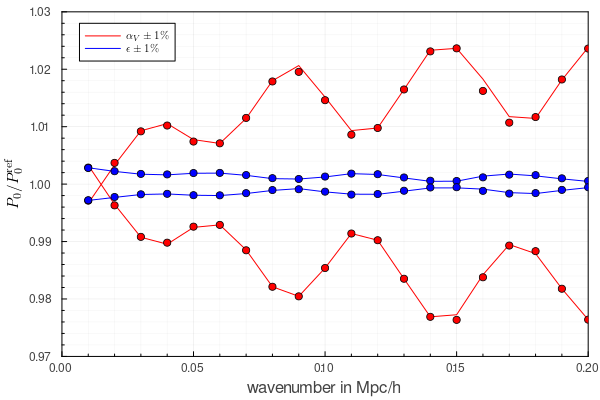

In [153]:
αV = 1.01
ϵ = 1.00
p0 = pkprime(kgrid, L0, αV, ϵ)/2
p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
p0th = p0ref + p2ref*(ϵ-1)*3/5 + dp2/5*(ϵ-1) + dp0*(αV-1)
plot(kgrid, p0./p0ref, color=:red, label=L"\alpha_V \pm 1\%")
plot!(kgrid, p0th./p0ref, color=:red, seriestype=:scatter, label=:none)
αV = 0.99
ϵ = 1.00
p0 = pkprime(kgrid, L0, αV, ϵ)/2
p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
p0th = p0ref + p2ref*(ϵ-1)*3/5 + dp2/5*(ϵ-1) + dp0*(αV-1)
plot!(kgrid, p0./p0ref, color=:red, label=:none)
plot!(kgrid, p0th./p0ref, color=:red, seriestype=:scatter, label=:none)
αV = 1.00
ϵ = 1.01
p0 = pkprime(kgrid, L0, αV, ϵ)/2
p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
p0th = p0ref + p2ref*(ϵ-1)*3/5 + dp2/5*(ϵ-1) + dp0*(αV-1)
plot!(kgrid, p0./p0ref, color=:blue, label=L"\epsilon \pm 1\%")
plot!(kgrid, p0th./p0ref, color=:blue, seriestype=:scatter, label=:none)
αV = 1.00
ϵ = 0.99
p0 = pkprime(kgrid, L0, αV, ϵ)/2
p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
p0th = p0ref + p2ref*(ϵ-1)*0.6 + dp2*(ϵ-1)/5 + dp0*(αV-1)
plot!(kgrid, p0./p0ref, color=:blue, label=:none, legend=:topleft)
plot!(kgrid, p0th./p0ref, color=:blue, seriestype=:scatter, label=:none)
plot!(xlabel="wavenumber in Mpc/h", ylabel=L"P_0/P^\mathrm{ref}_0")
plot!(xrange=(0,0.20), yrange=(0.97,1.03),grid=true,framestyle=:box,fontfamily="Arial",minorticks=:true,minorgrid=true)


In [164]:
function solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
    μ12 = (k1^2 + k2^2 - k3^2)/(2*k1*k2)
    μ31 = (k3^2 + k1^2 - k2^2)/(2*k3*k1)
    μ23 = (k2^2 + k3^2 - k1^2)/(2*k2*k3)
    μ3 = - μ1*μ12 - sqrt(1 - μ1^2)*sqrt(1 - μ12^2)*cos(ϕ)
    μ2 = -(μ1*k1 + μ3*k3)/k2
    return μ2, μ3, μ12, μ23, μ31
end

function tree_level_bk(μ1, ϕ, k1, k2, k3, b1, b2, f, pk)

    pk1 = pk(k1)
    pk2 = pk(k2)
    pk3 = pk(k3)

    μ2, μ3, μ12, μ23, μ31 = solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
 
    Z1k1 = b1 + f*μ1^2
    Z1k2 = b1 + f*μ2^2
    Z1k3 = b1 + f*μ3^2
 
    F12 = 5/7 + μ12/2*(k1/k2 + k2/k1) + 2/7*μ12^2
    F23 = 5/7 + μ23/2*(k2/k3 + k3/k2) + 2/7*μ23^2
    F31 = 5/7 + μ31/2*(k3/k1 + k1/k3) + 2/7*μ31^2
 
    G12 = 3/7 + μ12/2*(k1/k2 + k2/k1) + 4/7*μ12^2
    G23 = 3/7 + μ23/2*(k2/k3 + k3/k2) + 4/7*μ23^2
    G31 = 3/7 + μ31/2*(k3/k1 + k1/k3) + 4/7*μ31^2
 
    Z2k12 = b2/2. + b1*F12 + f*μ3^2*G12
    Z2k12 -= f*μ3*k3/2*(μ1/k1*Z1k2 + μ2/k2*Z1k1)
    Z2k23 = b2/2. + b1*F23 + f*μ1^2*G23
    Z2k23 -= f*μ1*k1/2*(μ2/k2*Z1k3 + μ3/k3*Z1k2)
    Z2k31 = b2/2. + b1*F31 + f*μ2^2*G31
    Z2k31 -= f*μ2*k2/2*(μ3/k3*Z1k1 + μ1/k1*Z1k3)

    Bi = Z2k12*Z1k1*Z1k2*pk1*pk2
    Bi += Z2k23*Z1k2*Z1k3*pk2*pk3
    Bi += Z2k31*Z1k3*Z1k1*pk3*pk1
 
    return 2*Bi 
end

function bk5d(μ, ϕ, k1, k2, k3)
    return tree_level_bk(μ, ϕ, k1, k2, k3, 2, 0.6, 0.7, pk_itp)
end

bk5d (generic function with 1 method)

In [170]:
function b00equi(kgrid, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 2:Nk
        pp[i] = hcubature(x -> bk5d(μp(kgrid[i], x[1], αV, ϵ), x[2], kp(kgrid[i], x[1], αV, ϵ), kp(kgrid[i], x[1], αV, ϵ), kp(kgrid[i], x[1], αV, ϵ))/2/sqrt(π)*sin(x[1]), [0, 0], [π, 2*π], reltol=1e-4)[1]
    end
    return pp
end

b00equi (generic function with 1 method)

In [171]:
b00equi(kgrid, 1.00, 1.00)

DomainError: DomainError with -1.4674011002723395:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [169]:
kgrid

21-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 0.12
 0.13
 0.14
 0.15
 0.16
 0.17
 0.18
 0.19
 0.2